# Calculating Biomass at 5 Neon Sites

This code is derived from https://www.neonscience.org/resources/learning-hub/tutorials/calc-biomass-py

In [5]:
import numpy as np
import os
from osgeo import gdal, osr
import matplotlib.pyplot as plt
import sys
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import rasterio as rio
%matplotlib inline 

In [6]:
#Import biomass specific libraries
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from sklearn.ensemble import RandomForestRegressor

In [17]:
#Define plot band array function

def plot_band_array(band_array,image_extent,title,cmap_title,colormap,colormap_limits):
    plt.imshow(band_array,extent=image_extent)
    cbar = plt.colorbar(); plt.set_cmap(colormap); plt.clim(colormap_limits)
    cbar.set_label(cmap_title,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)

In [18]:
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [8]:
chm_file = '/Users/Hannah/Downloads/Project/Data/DP3.30015.001/2019/FullSite/D16/2019_WREF_3/L3/DiscreteLidar/CanopyHeightModelGtif/NEON_D16_WREF_DP3_573000_5069000_CHM.tif'
!gdalinfo $chm_dataset

Usage: gdalinfo [--help-general] [-json] [-mm] [-stats] [-hist] [-nogcp] [-nomd]
                [-norat] [-noct] [-nofl] [-checksum] [-proj4]
                [-listmdd] [-mdd domain|`all`] [-wkt_format WKT1|WKT2|...]*
                [-sd subdataset] [-oo NAME=VALUE]* [-if format]* datasetname

FAILURE: No datasource specified.


In [9]:
#Open the CHM file with GDAL
chm_dataset = gdal.Open(chm_file)

In [10]:
!gdalinfo $chm_dataset

/bin/bash: -c: line 0: syntax error near unexpected token `>'
/bin/bash: -c: line 0: `gdalinfo <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fed32befe70> >'


In [11]:
import rasterio as rio
chm_rio = rio.open(chm_file)
chm_rio.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 1000, 'height': 1000, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(1.0, 0.0, 573000.0,
       0.0, -1.0, 5070000.0), 'tiled': False, 'interleave': 'band'}

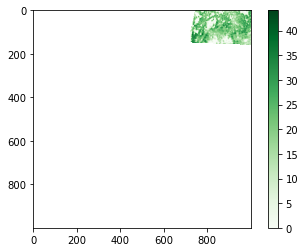

In [24]:
srtm_proj = chm_rio.read(1, masked=True)
f, ax = plt.subplots()
srtm = chm_rio.read(1, masked=True)
m = ax.imshow(srtm)
plt.colorbar(m)

In [13]:
#Get info from chm file for outputting results
just_chm_file = os.path.basename(chm_file)
just_chm_file_split = just_chm_file.split(sep="_")

In [20]:
#Open the CHM file with GDAL
chm_dataset = gdal.Open(chm_file)

#Get the raster band object
chm_raster = chm_dataset.GetRasterBand(1)

#Get the NO DATA value
noDataVal_chm = chm_raster.GetNoDataValue()

#Get required metadata from CHM file
cols_chm = chm_dataset.RasterXSize
rows_chm = chm_dataset.RasterYSize
bands_chm = chm_dataset.RasterCount
mapinfo_chm =chm_dataset.GetGeoTransform()
xMin = mapinfo_chm[0]
yMax = mapinfo_chm[3]
xMax = xMin + chm_dataset.RasterXSize/mapinfo_chm[1]
yMin = yMax + chm_dataset.RasterYSize/mapinfo_chm[5]
image_extent = (xMin,xMax,yMin,yMax)

In [15]:
!gdalinfo $chm_dataset

/bin/bash: -c: line 0: syntax error near unexpected token `>'
/bin/bash: -c: line 0: `gdalinfo <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fed380c31b0> >'


<ipython-input-23-abf5888b3553>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  chm_array = chm_raster.ReadAsArray(0,0,cols_chm,rows_chm).astype(np.float)


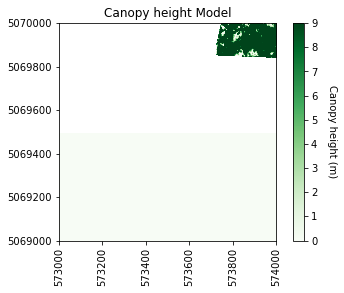

In [23]:
#Plot the original CHM
plt.figure(1)
chm_array = chm_raster.ReadAsArray(0,0,cols_chm,rows_chm).astype(np.float)

#PLot the CHM figure
plot_band_array(chm_array,image_extent,'Canopy height Model','Canopy height (m)','Greens',[0, 9])
plt.savefig(just_chm_file_split[0]
            +'_'+just_chm_file_split[1]+'_'+just_chm_file_split[2]+'_'+just_chm_file_split[3]+'_'
            +just_chm_file_split[4]+'_'+just_chm_file_split[5]+'_'+'CHM.png',
            dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)

In [22]:
#Smooth the CHM using a gaussian filter to remove spurious points
chm_array_smooth = ndi.gaussian_filter(chm_array,1,mode='constant',cval=0,truncate=2.0)
chm_array_smooth[chm_array==0] = 0 

#Save the smoothed CHM
array2raster('/home/jovyan/NEON_CO2_Macrosystems_LIDAR/Code/Data/DP3.30015.001/2019_WREF_3/New/chm_filter.tif',
             (xMin,yMax),1,-1,np.array(chm_array_smooth/10000,dtype=float),32611)

AttributeError: 'NoneType' object has no attribute 'SetGeoTransform'

In [16]:
chm_array_smooth

array([[        nan,         nan,         nan, ..., 19.73710752,
        22.5981585 , 18.4651557 ],
       [        nan,         nan,         nan, ..., 27.19022748,
        30.94563435, 25.19283469],
       [        nan,         nan,         nan, ..., 29.82236671,
        33.17533101, 26.74542477],
       ...,
       [        nan,         nan,         nan, ..., 52.73694024,
        50.46458428, 37.72535445],
       [        nan,         nan,         nan, ..., 50.89396283,
        49.55541466, 37.58264788],
       [        nan,         nan,         nan, ..., 38.04755957,
        37.36900453, 28.52943958]])

In [22]:
#Calculate local maximum points in the smoothed CHM
local_maxi = peak_local_max(chm_array_smooth,min_distance=10, threshold_abs=0, threshold_rel=0, indices=False)

<ipython-input-22-f35fc26c771a>:2: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(chm_array_smooth,min_distance=10, threshold_abs=0, threshold_rel=0, indices=False)


In [23]:
np.count_nonzero(local_maxi)

896

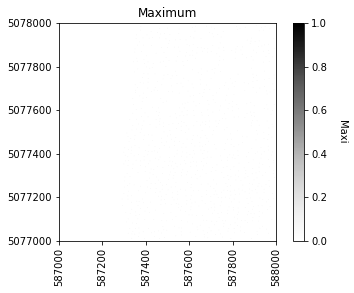

In [24]:
#Plot the local maximums
plt.figure(2)
plot_band_array(local_maxi,image_extent,'Maximum','Maxi','Greys',[0, 1])
plt.savefig(just_chm_file_split[0]+'_'+just_chm_file_split[1]+'_'+just_chm_file_split[2]+'_'+just_chm_file_split[3]+'_'+just_chm_file_split[4]+'_'
            +just_chm_file_split[5]+'_'+'Maximums.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)

In [27]:
#Identify all the maximum points
markers = ndi.label(local_maxi)[0]

896

In [28]:
#Create a CHM mask so the segmentation will only occur on the trees
chm_mask = chm_array_smooth
chm_mask[chm_array_smooth != 0] = 1

In [29]:
#Perfrom watershed segmentation        
labels = watershed(chm_array_smooth, markers, mask=chm_mask)

/srv/conda/envs/notebook/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


In [30]:
#Get the properties of each segment
tree_properties = regionprops(labels,chm_array, ['Area','BoundingBox','Centroid','Orientation','MajorAxisLength','MinorAxisLength','MaxIntensity','MinIntensity'])

In [31]:
#Determine how many individual trees were identified
max_labels = labels.max()
segment_labels = np.zeros(max_labels+1)
segment_id = np.zeros(max_labels+1)

for counter in range (1,max_labels+1):
    segment_labels[counter] = len(labels[labels==counter])
    segment_id[counter]=counter

#Remove the non-zero elements
segment_id = segment_id[np.nonzero(segment_labels)]

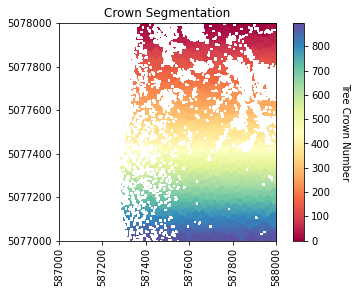

In [32]:
#Change the lebels to flow and plot them and save as raster
labels = np.array((labels),dtype=float)
plt.figure(3)
array2raster('/home/jovyan/NEON_CO2_Macrosystems_LIDAR/Code/Data/DP3.30015.001/2019_WREF_3/New/SegmentedData.tif',(xMin,yMax),1,-1,labels,32611)
#Change the zero labels to nans so they won't show up in the plot
labels[labels==0] = np.nan

#Plot the segments      
plot_band_array(labels,image_extent,'Crown Segmentation','Tree Crown Number','Spectral',[0, max_labels])
plt.savefig(just_chm_file_split[0]+'_'+just_chm_file_split[1]+'_'+just_chm_file_split[2]+'_'+just_chm_file_split[3]+'_'+just_chm_file_split[4]+'_'
            +just_chm_file_split[5]+'_'+'Segmentation.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)

In [34]:
#Define several of the predictor variables
area=np.zeros(len(tree_properties))
diameter=np.zeros(len(tree_properties))
max_tree_height=np.zeros(len(tree_properties))
min_tree_height=np.zeros(len(tree_properties))

#Retreive the predictor variables from the region properties
for counter in range(0,len(tree_properties)):

    area[counter] = tree_properties[counter]['Area']
    diameter[counter] = tree_properties[counter]['MajorAxisLength']        
    max_tree_height[counter] =  tree_properties[counter]['MaxIntensity']    
    min_tree_height[counter] = tree_properties[counter]['MinIntensity'] 

In [35]:
#Define the remaining predictor variables

crown_geometric_volume_full=np.zeros(len(segment_id))
crown_geometric_volume_50th_percentile=np.zeros(len(segment_id))
crown_geometric_volume_60th_percentile=np.zeros(len(segment_id))
crown_geometric_volume_70th_percentile=np.zeros(len(segment_id))
percentile_50th=np.zeros(len(segment_id))
percentile_60th=np.zeros(len(segment_id))
percentile_70th=np.zeros(len(segment_id))

In [36]:
#Cycle through all of the tree segments    
counter=0
for segment in segment_id:
    #Pull out the tree of interest
    indexes_of_tree = np.asarray(np.where(labels==segment)).T
    tree_data = chm_array[indexes_of_tree[:,0],indexes_of_tree[:,1]]
    #Calculate the geometric volume 
    crown_geometric_volume_full[counter]=np.sum([tree_data-np.min(tree_data)])

    #Pull out 50th percentile stats
    percentile_50th[counter]=np.percentile(tree_data,50)
    tree_data_50th = chm_array[indexes_of_tree[:,0],indexes_of_tree[:,1]]
    tree_data_50th[tree_data_50th>percentile_50th[counter]] = percentile_50th[counter]
    crown_geometric_volume_50th_percentile[counter]=np.sum([tree_data_50th-min_tree_height[counter]])

    #Pull out 60th percentile stats    
    percentile_60th[counter]=np.percentile(tree_data,60)
    tree_data_60th = chm_array[indexes_of_tree[:,0],indexes_of_tree[:,1]]
    tree_data_60th[tree_data_60th>percentile_60th[counter]] = percentile_60th[counter]
    crown_geometric_volume_60th_percentile[counter]=np.sum([tree_data_60th-min_tree_height[counter]])

    #Pull out 60th percentile stats 
    percentile_70th[counter]=np.percentile(tree_data,70)
    tree_data_70th = chm_array[indexes_of_tree[:,0],indexes_of_tree[:,1]]
    tree_data_70th[tree_data_70th>percentile_70th[counter]] = percentile_70th[counter]
    crown_geometric_volume_70th_percentile[counter]=np.sum([tree_data_70th-min_tree_height[counter]])

    counter=counter+1

In [37]:
#Define the file of training data  
training_data_file = '/home/jovyan/NEON_CO2_Macrosystems_LIDAR/Code/Data/SJER_Biomass_Training.csv'

#Read in the training data from a CSV file
training_data = np.genfromtxt(training_data_file,delimiter=',') 

#Grab the biomass (Y) from the first line
biomass = training_data[:,0]

#Grab the biomass prdeictors from the remaining lines
biomass_predictors = training_data[:,1:12]

In [38]:
#Define paraemters for Random forest regressor
max_depth = 30

#Define regressor rules
regr_rf = RandomForestRegressor(max_depth=max_depth, random_state=2)

#Fit the biomass to regressor variables
regr_rf.fit(biomass_predictors,biomass)


RandomForestRegressor(max_depth=30, random_state=2)

In [39]:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)

RandomForestRegressor(max_depth=30, min_impurity_split=1e-07, n_estimators=10,
                      n_jobs=1, random_state=2)

In [40]:
#Stack the predictor variables for all the individual trees
all_training_data = np.stack([area,diameter,max_tree_height,min_tree_height,percentile_50th,percentile_60th,percentile_70th,crown_geometric_volume_full,
                              crown_geometric_volume_50th_percentile,crown_geometric_volume_60th_percentile,crown_geometric_volume_70th_percentile],axis=-1)

In [41]:
#Apply the model to the 
pred_biomass = regr_rf.predict(all_training_data)

In [42]:
#Set an out raster with the same size as the labels
biomass_out = labels

#Set counter to zero
counter = 0
#Assign each tree by the associated biomass
for segment in segment_id:
    biomass_out[biomass_out==segment] = pred_biomass[counter]
    counter = counter+1

Sum of biomass is  8709070.470089521  kg


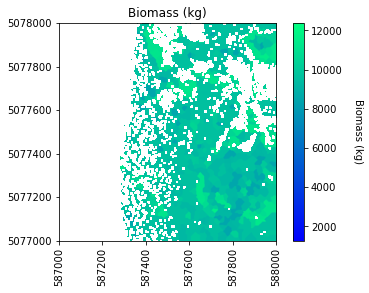

In [43]:
#Get biomass stats for plotting
mean_biomass = np.mean(pred_biomass)
std_biomass = np.std(pred_biomass)
min_biomass = np.min(pred_biomass)
sum_biomass = np.sum(pred_biomass)

print('Sum of biomass is ',sum_biomass,' kg')

#Plot the biomass!
plt.figure(5)
plot_band_array(biomass_out,image_extent,'Biomass (kg)','Biomass (kg)','winter',[min_biomass+std_biomass, mean_biomass+std_biomass*3])
plt.savefig(just_chm_file_split[0]+'_'+just_chm_file_split[1]+'_'+just_chm_file_split[2]+'_'+just_chm_file_split[3]+'_'+just_chm_file_split[4]+'_'+just_chm_file_split[5]+'_'+'Biomass.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)
array2raster('biomass.tif',(xMin,yMax),1,-1,np.array(biomass_out,dtype=float),32611)

In [2]:
import gdal_merge as gm

ModuleNotFoundError: No module named 'gdal_merge'